# RoBERTa Deep Learning Fake News Classifier

Este notebook implementa um classificador de deep learning usando RoBERTa para detectar notícias falsas usando o dataset FakeBr News.

## Objetivo
Criar um modelo RoBERTa que classifique notícias como verdadeiras ou falsas baseado no texto pré-processado (`preprocessed_text`).

In [2]:
import torch
print("cuda available:", torch.cuda.is_available())
print("torch version:", torch.__version__)
if torch.cuda.is_available():
    print("gpu:", torch.cuda.get_device_name(0))


cuda available: False
torch version: 2.8.0+cpu


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW  # Importar do torch.optim em vez de transformers
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Configuração de visualização
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Verificar se GPU está disponível
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


## 1. Carregamento dos Dados

In [4]:
# Carregar dados do parquet
df = pd.read_parquet('../data/processed/fakebr_news.parquet')

print(f"Dataset shape: {df.shape}")
print(f"\nColunas disponíveis: {df.columns.tolist()}")
print(f"\nDistribuição de classes:")
print(df['is_fake'].value_counts())
print(f"\nPorcentagem:")
print(df['is_fake'].value_counts(normalize=True) * 100)

Dataset shape: (7200, 31)

Colunas disponíveis: ['id', 'full_text', 'preprocessed_text', 'size_normalized_text', 'author', 'link', 'category', 'publication_date', 'is_fake', 'text_hash', 'created_at', 'updated_at', 'num_tokens', 'num_palavras_sem_pontuacao', 'num_tipos', 'num_links_internos', 'num_palavras_maiuscula', 'num_verbos', 'num_nomes', 'num_adjetivos', 'num_adverbios', 'num_pronomes', 'num_caracteres', 'avg_sent_length', 'avg_word_length', 'pausality', 'emotiveness', 'diversity', 'percentage_spelling_errors', 'publication_date_as_date', 'sequence']

Distribuição de classes:
is_fake
True     3600
False    3600
Name: count, dtype: int64

Porcentagem:
is_fake
True     50.0
False    50.0
Name: proportion, dtype: float64


In [5]:
# Verificar dados faltantes no preprocessed_text
print(f"Valores nulos em preprocessed_text: {df['preprocessed_text'].isnull().sum()}")
print(f"Valores vazios em preprocessed_text: {(df['preprocessed_text'] == '').sum()}")

# Remover linhas com texto vazio ou nulo
df_clean = df[df['preprocessed_text'].notna() & (df['preprocessed_text'] != '')].copy()
print(f"\nDataset após limpeza: {df_clean.shape}")

Valores nulos em preprocessed_text: 0
Valores vazios em preprocessed_text: 0

Dataset após limpeza: (7200, 31)


## 2. Preparação dos Dados

In [6]:
# Separar features (X) e target (y)
X = df_clean['preprocessed_text'].values
y = df_clean['is_fake'].values.astype(int)

print(f"Shape de X: {X.shape}")
print(f"Shape de y: {y.shape}")
print(f"\nDistribuição de y:")
print(f"Fake (1): {y.sum()} ({y.sum()/len(y)*100:.2f}%)")
print(f"True (0): {len(y) - y.sum()} ({(len(y) - y.sum())/len(y)*100:.2f}%)")

Shape de X: (7200,)
Shape de y: (7200,)

Distribuição de y:
Fake (1): 3600 (50.00%)
True (0): 3600 (50.00%)


In [7]:
# Split estratificado mantendo os pares juntos
unique_sequences = df_clean['sequence'].unique()
train_sequences, test_sequences = train_test_split(
    unique_sequences, 
    test_size=0.2, 
    random_state=42
)

# Criar máscaras para train e test
train_mask = df_clean['sequence'].isin(train_sequences)
test_mask = df_clean['sequence'].isin(test_sequences)

X_train = df_clean[train_mask]['preprocessed_text'].values
X_test = df_clean[test_mask]['preprocessed_text'].values
y_train = df_clean[train_mask]['is_fake'].values.astype(int)
y_test = df_clean[test_mask]['is_fake'].values.astype(int)

print(f"Tamanho do conjunto de treino: {len(X_train)}")
print(f"Tamanho do conjunto de teste: {len(X_test)}")
print(f"\nDistribuição no treino - Fake: {y_train.sum()}, True: {len(y_train) - y_train.sum()}")
print(f"Distribuição no teste - Fake: {y_test.sum()}, True: {len(y_test) - y_test.sum()}")

Tamanho do conjunto de treino: 5760
Tamanho do conjunto de teste: 1440

Distribuição no treino - Fake: 2880, True: 2880
Distribuição no teste - Fake: 720, True: 720


## 3. Configuração do RoBERTa

Vamos usar o modelo RoBERTa pré-treinado em português (BERTimbau).

In [8]:
# Configurações
MODEL_NAME = 'neuralmind/bert-base-portuguese-cased'  # BERTimbau
MAX_LENGTH = 128
BATCH_SIZE = 8
EPOCHS = 3
LEARNING_RATE = 2e-5

# Carregar tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print(f"Tokenizer carregado: {MODEL_NAME}")

Tokenizer carregado: neuralmind/bert-base-portuguese-cased


## 4. Criação do Dataset PyTorch

In [9]:
class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Criar datasets
train_dataset = NewsDataset(X_train, y_train, tokenizer, MAX_LENGTH)
test_dataset = NewsDataset(X_test, y_test, tokenizer, MAX_LENGTH)

# Criar dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 720
Test batches: 180


## 5. Criação e Configuração do Modelo

In [10]:
# Carregar modelo
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2
)
model = model.to(device)

# Configurar otimizador
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

# Configurar scheduler
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

print(f"Modelo carregado: {MODEL_NAME}")
print(f"Total de parâmetros: {sum(p.numel() for p in model.parameters())}")
print(f"Total de steps de treinamento: {total_steps}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Modelo carregado: neuralmind/bert-base-portuguese-cased
Total de parâmetros: 108924674
Total de steps de treinamento: 2160


## 6. Funções de Treinamento e Avaliação

In [11]:
def train_epoch(model, data_loader, optimizer, scheduler, device):
    model.train()
    losses = []
    correct_predictions = 0
    
    progress_bar = tqdm(data_loader, desc='Training')
    
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        logits = outputs.logits
        
        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
        progress_bar.set_postfix({'loss': loss.item()})
    
    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

def eval_model(model, data_loader, device):
    model.eval()
    losses = []
    correct_predictions = 0
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc='Evaluating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            logits = outputs.logits
            
            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())
            
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses), predictions, true_labels

## 7. Treinamento do Modelo

In [12]:
history = {
    'train_acc': [],
    'train_loss': [],
    'val_acc': [],
    'val_loss': []
}

best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'\nEpoch {epoch + 1}/{EPOCHS}')
    print('-' * 50)
    
    train_acc, train_loss = train_epoch(
        model,
        train_loader,
        optimizer,
        scheduler,
        device
    )
    
    print(f'Train loss: {train_loss:.4f} | Train accuracy: {train_acc:.4f}')
    
    val_acc, val_loss, _, _ = eval_model(
        model,
        test_loader,
        device
    )
    
    print(f'Val loss: {val_loss:.4f} | Val accuracy: {val_acc:.4f}')
    
    history['train_acc'].append(train_acc.item())
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc.item())
    history['val_loss'].append(val_loss)
    
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), '../models/roberta_best_model.bin')
        best_accuracy = val_acc


Epoch 1/3
--------------------------------------------------


Training: 100%|██████████| 720/720 [59:57<00:00,  5.00s/it, loss=0.00113] 


Train loss: 0.1870 | Train accuracy: 0.9411


Evaluating: 100%|██████████| 180/180 [03:46<00:00,  1.26s/it]


Val loss: 0.1179 | Val accuracy: 0.9743

Epoch 2/3
--------------------------------------------------


Training: 100%|██████████| 720/720 [58:18<00:00,  4.86s/it, loss=0.000204] 


Train loss: 0.0492 | Train accuracy: 0.9898


Evaluating: 100%|██████████| 180/180 [03:40<00:00,  1.22s/it]


Val loss: 0.1731 | Val accuracy: 0.9694

Epoch 3/3
--------------------------------------------------


Training: 100%|██████████| 720/720 [58:42<00:00,  4.89s/it, loss=0.000176]


Train loss: 0.0140 | Train accuracy: 0.9967


Evaluating: 100%|██████████| 180/180 [03:40<00:00,  1.23s/it]


Val loss: 0.0973 | Val accuracy: 0.9812


## 8. Visualização do Treinamento

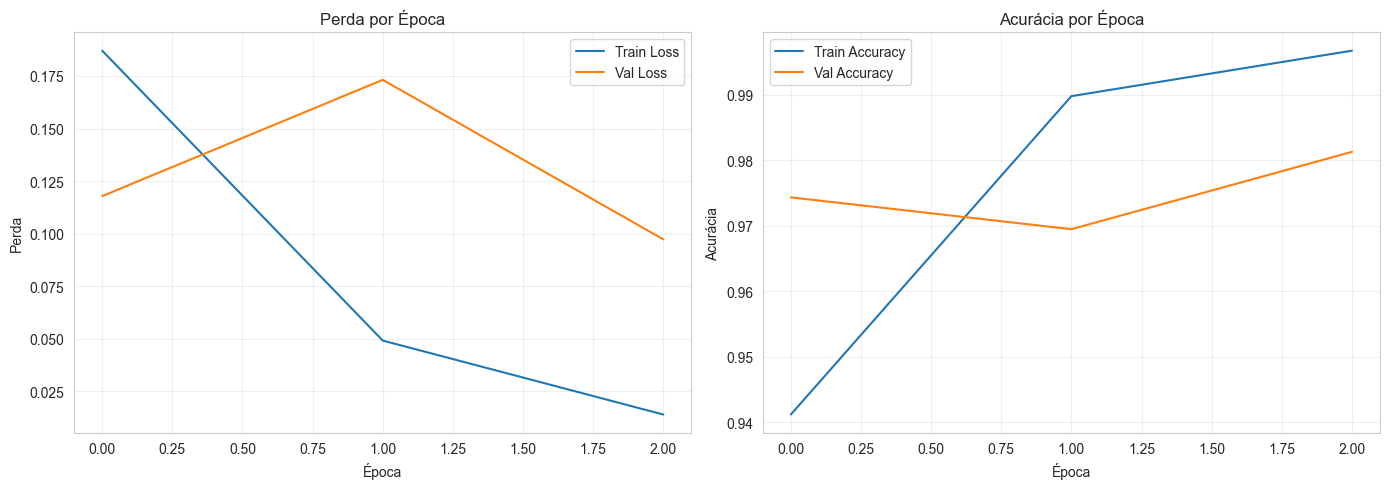

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history['train_loss'], label='Train Loss')
axes[0].plot(history['val_loss'], label='Val Loss')
axes[0].set_title('Perda por Época')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Perda')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history['train_acc'], label='Train Accuracy')
axes[1].plot(history['val_acc'], label='Val Accuracy')
axes[1].set_title('Acurácia por Época')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Acurácia')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Avaliação Final

In [14]:
# Carregar melhor modelo
model.load_state_dict(torch.load('../models/roberta_best_model.bin'))

# Avaliar no conjunto de teste
test_acc, test_loss, y_pred, y_true = eval_model(model, test_loader, device)

print("\n=== Resultados Finais ===")
print(f"Acurácia no teste: {test_acc:.4f}")
print(f"F1-Score no teste: {f1_score(y_true, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['True News', 'Fake News']))

Evaluating: 100%|██████████| 180/180 [03:40<00:00,  1.22s/it]


=== Resultados Finais ===
Acurácia no teste: 0.9812
F1-Score no teste: 0.9814

Classification Report:
              precision    recall  f1-score   support

   True News       0.99      0.97      0.98       720
   Fake News       0.97      0.99      0.98       720

    accuracy                           0.98      1440
   macro avg       0.98      0.98      0.98      1440
weighted avg       0.98      0.98      0.98      1440



## 10. Matriz de Confusão

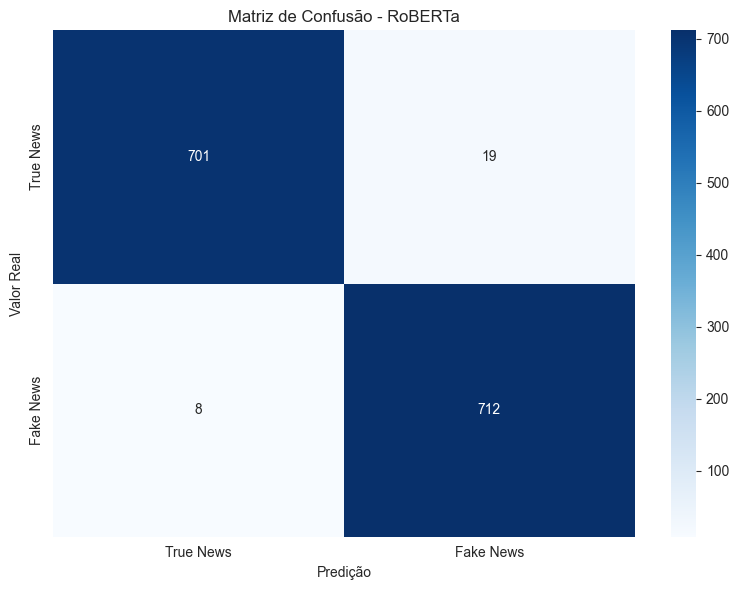


Métricas da Matriz de Confusão:
True Negatives (TN): 701
False Positives (FP): 19
False Negatives (FN): 8
True Positives (TP): 712

Precisão: 0.9740
Recall: 0.9889


In [15]:
# Matriz de Confusão
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['True News', 'Fake News'],
            yticklabels=['True News', 'Fake News'])
plt.title('Matriz de Confusão - RoBERTa')
plt.ylabel('Valor Real')
plt.xlabel('Predição')
plt.tight_layout()
plt.show()

# Calcular métricas da matriz de confusão
tn, fp, fn, tp = cm.ravel()
print(f"\nMétricas da Matriz de Confusão:")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")
print(f"\nPrecisão: {tp/(tp+fp):.4f}")
print(f"Recall: {tp/(tp+fn):.4f}")

## 11. Teste com Exemplos

In [16]:
def predict_text(text, model, tokenizer, device, max_length=512):
    model.eval()
    
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, prediction = torch.max(outputs.logits, dim=1)
    
    return "FAKE" if prediction.item() == 1 else "TRUE"

# Testar com alguns exemplos
print("Exemplos de Predições:\n")
for i in range(5):
    idx = np.random.randint(0, len(X_test))
    text = X_test[idx]
    real_label = "FAKE" if y_test[idx] == 1 else "TRUE"
    predicted_label = predict_text(text, model, tokenizer, device)
    
    print(f"Texto: {text[:100]}...")
    print(f"Real: {real_label} | Predição: {predicted_label}")
    print(f"Correto: {'✓' if real_label == predicted_label else '✗'}")
    print("-" * 80)
    print()

Exemplos de Predições:

Texto: saiu sentenca! lula condenado 9 anos prisao. . sentenca crimes corrupcao passiva lavagem dinheiro an...
Real: FAKE | Predição: FAKE
Correto: ✓
--------------------------------------------------------------------------------

Texto: nova operacao pf podera estopim eduardo cunha comece jogar lama ventilador. deflagrada ultima sexta-...
Real: FAKE | Predição: FAKE
Correto: ✓
--------------------------------------------------------------------------------

Texto: procuradora-geral republica nomeada, raquel dodge, divulgou nesta terca-feira, 22, nomes equipe mand...
Real: TRUE | Predição: TRUE
Correto: ✓
--------------------------------------------------------------------------------

Texto: porta-avioes americano carl vinson pronto atacar coreia norte. uss carl vinson posicionado porto bus...
Real: FAKE | Predição: FAKE
Correto: ✓
--------------------------------------------------------------------------------

Texto: forca-tarefa operacao lava jato parana de

## 12. Conclusões

Este notebook implementou um classificador de deep learning usando RoBERTa (BERTimbau) para detectar notícias falsas.

### Principais Resultados:
- Utilizamos o modelo BERTimbau pré-treinado em português
- O modelo foi fine-tuned no dataset FakeBr News
- Implementamos data augmentation através do split estratificado por sequências
- Utilizamos técnicas de regularização (gradient clipping, learning rate scheduling)

### Vantagens do RoBERTa:
- Captura contexto semântico profundo do texto
- Pré-treinado em grande corpus de português
- Melhor performance em tarefas de classificação de texto

### Próximos Passos:
1. Experimentar com diferentes modelos (GPT-2, T5, etc.)
2. Implementar ensemble com modelos tradicionais (SVM, Naive Bayes)
3. Adicionar features adicionais (metadados, features linguísticas)
4. Implementar técnicas de interpretabilidade (LIME, SHAP)